In [1]:
import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from graphs import lhrf_model, FFN_lhrf_dae_model

/lclhome/dli/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1.Load MNIST & Select Dataset 

Extracting ./MNIST/train-images-idx3-ubyte.gz
Extracting ./MNIST/train-labels-idx1-ubyte.gz
Extracting ./MNIST/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/t10k-labels-idx1-ubyte.gz
The number of training samples is 12873, including sample 1: 6742, sample 3: 6131
The number of testing samples is 2145, including digit 1: 1135, digit 3: 1010


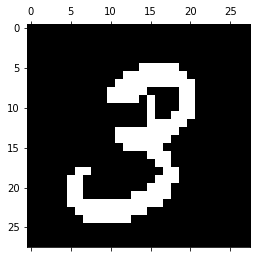

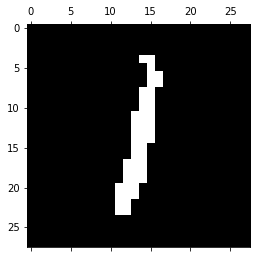

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data_dir = './MNIST'
mnist_input = input_data.read_data_sets(data_dir, one_hot = True)
#select two classes:digit '1' and '3'
dataset_images = np.vstack((mnist_input.train.images, mnist_input.validation.images, mnist_input.test.images))
dataset_labels = np.vstack((mnist_input.train.labels, mnist_input.validation.labels, mnist_input.test.labels))
is_digit_1, is_digit_3 = (dataset_labels[:, 1] == 1.), (dataset_labels[:, 3] == 1.)
selected_training = is_digit_1[:60000] + is_digit_3[:60000]
selected_test = is_digit_1[60000:] + is_digit_3[60000:]
selected = is_digit_1 + is_digit_3

#discretize the attributes, and round the pixel to be 0 or 1
training_x = np.round(dataset_images[:60000][selected_training], 0)
training_y = dataset_labels[:60000][selected_training][:, [1, 3]]
#discretize the attributes, and round the pixel to be 0 or 1
test_x = np.round(dataset_images[60000:][selected_test], 0)
test_y = dataset_labels[60000:][selected_test][:, [1, 3]]

#output some useful imformation
MSG = 'The number of training samples is {0}, including sample 1: {1}, sample 3: {2}' 
print MSG.format(training_x.shape[0], np.sum(is_digit_1[:60000]), np.sum(is_digit_3[:60000]))
MSG = 'The number of testing samples is {0}, including digit 1: {1}, digit 3: {2}' 
print MSG.format(test_x.shape[0], np.sum(is_digit_1[60000:]), np.sum(is_digit_3[60000:]))

for i in range(2):
    plt.matshow(training_x[i, :].reshape(28, 28), vmin = 0., vmax = 1., cmap = plt.cm.gray)
    plt.show()

# 2.Hyper-parameters

In [4]:
import utils
input_dims = training_x.shape[1]
hidden_dims =[32, 32]
output_dims =2
model_dir = os.path.join(data_dir, "model/")
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_save_dir = os.path.join(model_dir, "jfd/")
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)
    
_config = {
    'save_dir': model_save_dir,
    'n_epochs':30,
    'batch_size':128,
    'learning_rate':0.001,
    'keep_prob': 0.6,
    'input_dim' : input_dims,
    'output_dim' : output_dims,
    'hidden_dims': hidden_dims,
    'K' : 16,
    'L' : 16
}
args = utils.ParamWrapper(_config)

# 3.Learn to hash

In [5]:
#learning
lh_rf = lhrf_model(args, training_x, training_y[:,0])
#hashing
trainX_rps = lh_rf.learning_hashing_by_rf.hashing_func(training_x)
testX_rps = lh_rf.learning_hashing_by_rf.hashing_func(test_x)

[7 4 7 7 6 3 6 4 3 4]
[11  6 14 13 11  4  6  4  3 13]
[ 4  7  3 14 10 11 14  4  7 13]
[13 13 11  6  3  7 13  4 11  3]
[ 3  6 10  6  4  7  6 13  3 14]
[ 3 11  6  4  4  6  6  4 10 11]
[10  7  6  4  6  6 11  4 11  6]
[14  7  7  7 13 10 14  6  7 14]
[ 6  7  6  6 14 14  3  4 11  3]
[ 4  4 14  7 11  6 11  6  3 11]
[11 14 14  7  3  7 13 14  4  6]
[ 7  4  7  6  6  6  3  3 14  4]
[ 3  6  7  4  4  3  6  3 13  7]
[ 6  6 13  3  6 10  4  3 11 13]
[11 11  7  4 10 13  6  4  3  3]
[ 3  6 10  4 14  3 10 14  3  7]


# 4. Config DNN

In [6]:
#prepra data
train_input = utils.DataProducer(trainX_rps, training_y, args.batch_size, args.n_epochs, "train")
test_input = utils.DataProducer(testX_rps, test_y, args.batch_size, args.n_epochs, "test")

args.input_dim = list(trainX_rps.shape[1:])
args.input_dim.append(training_x.shape[1])
#bais
train_bias = np.array([[1., 1]], dtype = np.float32)
test_bias = np.array([[1., 1]], dtype = np.float32)

tf.reset_default_graph()
model = FFN_lhrf_dae_model(args)

In [7]:
#the probability of corrupting hashing codes
epsilon = 10.
sigma = epsilon/input_dims
mu = 0.0
def random_noises_dae(batch_size, onehot_dim, input_dim):
    prob = np.clip(np.random.randn() * sigma + mu, a_min = 0., a_max = 1.)
    return np.random.binomial(1, prob, (batch_size, args.L, onehot_dim))

def random_noises_vir(batch_size,  onehot_dim):
    return np.zeros((batch_size, args.L, onehot_dim))

# 5.Training

In [8]:
#dae training
saver_dae = tf.train.Saver(model.share_vars)
model_save_path = os.path.join(model_save_dir, "jfd.ckpt")
sess = tf.Session()
init = tf.global_variables_initializer()
with sess.as_default():
    sess.run(init)
    best_recon_loss = 5.
    best_iteration = 0
    #start DAE training
    for epoch in range(args.n_epochs):
            train_input.reset_cursor()
            for mini_batch, trainX_batch, trainy_batch in train_input.next_batch():
                train_dict = {model.x : trainX_batch,
                              model.noises: random_noises_dae(trainX_batch.shape[0], trainX_batch.shape[2], args.input_dim[2]),
                              model.is_training: True
                                  }
                _, dae_train_loss = sess.run([model.dae_optimizer, model.dae_loss],
                                                feed_dict= train_dict)

                
                iterations = epoch * train_input.mini_batches + mini_batch + 1
                if iterations % 100 == 0:
                    test_input.reset_cursor()
                    dae_test_loss = [sess.run(model.dae_loss, feed_dict = {model.x: testX_batch,
                                                                   model.noises: random_noises_vir(testX_batch.shape[0], testX_batch.shape[2]),
                                                                   model.is_training: False}) \
                                 for [_, testX_batch, testy_batch] in test_input.next_batch()
                    ]

                    if np.mean(dae_test_loss) < best_recon_loss:
                        #save model parameters
                        best_recon_loss = np.mean(dae_test_loss)
                        save_model_path = os.path.join(model_save_path + "model.ckpt")
                        saver_dae.save(sess, save_model_path)
                        print("the parameters of model saved at %s" % model_save_path)
                    MSG = "The iteration is {0}, epoch {1}/{2}, minibatch {3}/{4}, with training loss {5:.5} and test loss {6:.5}."
                    print(MSG.format(iterations, epoch + 1, args.n_epochs, mini_batch + 1, train_input.mini_batches, dae_train_loss, np.mean(dae_test_loss)))
                    

the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 100, epoch 1/30, minibatch 100/101, with training loss 0.13916 and test loss 0.14274.
the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 200, epoch 2/30, minibatch 99/101, with training loss 0.13484 and test loss 0.13462.
the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 300, epoch 3/30, minibatch 98/101, with training loss 0.11509 and test loss 0.11219.
the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 400, epoch 4/30, minibatch 97/101, with training loss 0.11403 and test loss 0.10945.
the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 500, epoch 5/30, minibatch 96/101, with training loss 0.12199 and test loss 0.10748.
the parameters of model saved at ./MNIST/model/jfd/jfd.ckpt
The iteration is 600, epoch 6/30, minibatch 95/101, with training loss 0.10353 and test loss 0.10467.
the parameters of model sav

In [9]:
#optimize classifier
#saver = tf.train.Saver()
with sess.as_default():
    saver_dae.restore(sess, save_model_path)
    best_iter = 0
    best_acc = 0.
    for epoch in range(args.n_epochs):
        train_input.reset_cursor()
        for mini_batch, trainX_batch, trainy_batch in train_input.next_batch():
            train_dict = {model.x : trainX_batch,
                          model.noises:random_noises_vir(trainX_batch.shape[0], trainX_batch.shape[2]),
                          model.y : trainy_batch,
                          model.bias: train_bias,
                          model.is_training: True
                          }
            _, train_loss, train_acc = sess.run([model.update, model.loss, model.acc],
                                                feed_dict= train_dict)
            iterations = epoch * train_input.mini_batches + mini_batch + 1
            if iterations % 100 == 0:
                test_input.reset_cursor()
                test_accs = [sess.run(model.acc, feed_dict = {model.x: testX_batch,
                                                              model.noises:random_noises_vir(testX_batch.shape[0], testX_batch.shape[2]),
                                                              model.y: testy_batch,
                                                              model.bias: test_bias,
                                                              model.is_training: False}) \
                             for [_, testX_batch, testy_batch] in test_input.next_batch()
                ]
                test_acc = np.mean(test_accs)

                MSG = "The iteration is {0}, epoch {1}/{2}, minibatch {3}/{4}, with training loss {5:.5}, training accuracy {6:.5} and test accuracy {7:.5}."
                print(MSG.format(iterations, epoch + 1, args.n_epochs, mini_batch + 1, train_input.mini_batches, train_loss, train_acc, test_acc))
                if best_acc < test_acc:
                    best_iter = iterations
                    best_acc = test_acc
                    MSG = "\tThe best test accuracy is {0:.5}, which achieves at iteration {1}, wiht test accuracy {2:.5}"
                    print(MSG.format(best_acc, best_iter, test_acc))
                    #save model parameters
                    #saver.save(sess, save_model_path)    

INFO:tensorflow:Restoring parameters from ./MNIST/model/jfd/jfd.ckptmodel.ckpt
The iteration is 100, epoch 1/30, minibatch 100/101, with training loss 0.063211, training accuracy 0.98438 and test accuracy 0.99235.
	The best test accuracy is 0.99235, which achieves at iteration 100, wiht test accuracy 0.99235
The iteration is 200, epoch 2/30, minibatch 99/101, with training loss 0.023903, training accuracy 0.98438 and test accuracy 0.99434.
	The best test accuracy is 0.99434, which achieves at iteration 200, wiht test accuracy 0.99434
The iteration is 300, epoch 3/30, minibatch 98/101, with training loss 0.11921, training accuracy 0.96094 and test accuracy 0.99449.
	The best test accuracy is 0.99449, which achieves at iteration 300, wiht test accuracy 0.99449
The iteration is 400, epoch 4/30, minibatch 97/101, with training loss 0.012267, training accuracy 1.0 and test accuracy 0.99403.
The iteration is 500, epoch 5/30, minibatch 96/101, with training loss 0.025104, training accuracy 1.

# ================Test Adversarial Examples================

In [10]:
#load adversarial examples
save_dir = "./MNIST"

save_path1 = os.path.join(save_dir, 'clean.data')
save_path2 = os.path.join(save_dir, 'fgsm_10.data')
save_path3 = os.path.join(save_dir, 'fgsm_20.data')
save_path4 = os.path.join(save_dir, 'fgsm_50.data')
save_path5 = os.path.join(save_dir, 'fgsm_100.data')
save_path_label = os.path.join(save_dir, 'clean.label')

save_path1_opt = os.path.join(save_dir, 'opt_5.data')
save_path2_opt = os.path.join(save_dir, 'opt_10.data')
save_path3_opt = os.path.join(save_dir, 'opt_20.data')

samples = utils.readdata_np(save_path1)
labels =  utils.readdata_np(save_path_label)
adv_examples_fgm_10 =  utils.readdata_np(save_path2)
adv_examples_fgm_20 =  utils.readdata_np(save_path3)
adv_examples_fgm_50 =  utils.readdata_np(save_path4)
adv_examples_fgm_100 =  utils.readdata_np(save_path5)

adv_examples_opt_5 =  utils.readdata_np(save_path1_opt)
adv_examples_opt_10 =  utils.readdata_np(save_path2_opt)
adv_examples_opt_20 =  utils.readdata_np(save_path3_opt)

In [11]:
def evaluate_adv_sampels(sess, adv_samples, labels):
    adv_hashing = lh_rf.learning_hashing_by_rf.hashing_func(adv_samples)
    eva_dict = {model.x : adv_hashing,
                model.y : labels,
                model.bias: test_bias,
                model.is_training: False
                }
    return sess.run(model.acc,feed_dict= train_dict)

In [12]:
acc_clean = evaluate_adv_sampels(sess, samples, labels)
acc_fgs_10 = evaluate_adv_sampels(sess, adv_examples_fgm_10, labels)
acc_fgs_20 = evaluate_adv_sampels(sess, adv_examples_fgm_20, labels)
acc_fgs_50 = evaluate_adv_sampels(sess, adv_examples_fgm_50, labels)
acc_fgs_100 = evaluate_adv_sampels(sess, adv_examples_fgm_100, labels)
acc_opt_5 = evaluate_adv_sampels(sess, adv_examples_opt_5, labels)
acc_opt_10 = evaluate_adv_sampels(sess, adv_examples_opt_10, labels)
acc_opt_20 = evaluate_adv_sampels(sess, adv_examples_opt_20, labels)
print("The accuracy on clean sampels is %.3f, vs that on adversarial exampels generated by fgm is %.3f, %.3f, %.3f, %.3f" \
      % (acc_clean, acc_fgs_10, acc_fgs_20, acc_fgs_50, acc_fgs_100))
print("The accuracy on adversarial examples generated by optimization method is %.3f, %.3f, %.3f" % \
      (acc_opt_5, acc_opt_10, acc_opt_20))

The accuracy on clean sampels is 1.000, vs that on adversarial exampels generated by fgm is 1.000, 1.000, 1.000, 1.000
The accuracy on adversarial examples generated by optimization method is 1.000, 1.000, 1.000
